In [11]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [12]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [230]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position =  1 / fcen *2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1/2

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2


# 3) MaterialGrid 생성
design_variables = mp.MaterialGrid(
    mp.Vector3(Nx, Ny),
    TiO2,    # weight=0일 때 매체
    SiO2,    # weight=1일 때 매체
    grid_type="U_MEAN"
)


design_region0 = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design+design_region_height/2, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

design_region1 = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design-design_region_height/2, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [231]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    ############################################################
    mp.Block(
        material=design_variables,
        size=design_region0.size,
        center=design_region0.center
    ),
    mp.Block(
        material=design_variables,
        size=design_region1.size,
        center=design_region1.center
    ),
    ############################################################
    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [232]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )

sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [234]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

# def mapping(x, eta, beta):
def mapping(x, eta_i, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta_i)

    # interpolate to actual materials
    return projected_field.flatten()

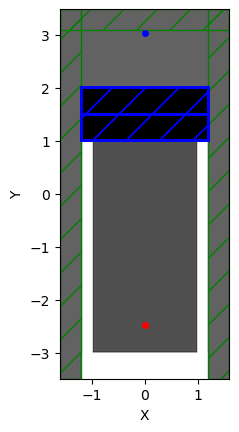

In [235]:
monitor_position_J, monitor_size = mp.Vector3(0, center_y_monitor_position+1/2), mp.Vector3(0,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position_J,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region0, design_region1],
    frequencies=[fcen],
    maximum_run_time=100,
)

opt.plot2D(True)

In [209]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [212]:
evaluation_history_adam = []
beta_history = []

cur_iter = [0]

numevl = 1

lr_history=[]

uf_history=[]
t_history=[]
adjgrad_history=[]
lr_history = []

optimizer = AdamOptimizer(lr=0.02, beta1=0.9)


def f(v, eta, cur_beta):
    size_each = Nx * Ny

    v1 = v[         : size_each]    # layer 0
    v2 = v[size_each: 2*size_each]  # layer 1

    rho1 = mapping(v1, eta, cur_beta)
    rho2 = mapping(v2, eta, cur_beta)


    f0_r, gradients = opt([rho1, rho2],
                          need_value=True,
                          need_gradient=True,
                          beta=cur_beta
                          )
    dJ1, dJ2 = gradients  # 각각 shape = (Ny, Nx)

    g1 = dJ1.flatten()
    g2 = dJ2.flatten()
    gradient = np.concatenate([g1, g2])  # 길이 = 2*Nx*Ny

    v_new, adam_lr, adam_uf, adam_m, adam_v, adam_t = \
        optimizer.update(v, gradient)

    beta_new = cur_beta + np.tanh((cur_beta - 0.5)*0.01)

    evaluation_history_adam.append(f0_r)
    beta_history.append(beta_new)
    cur_iter[0] += 1
    lr_history.append(adam_lr)
    uf_history.append(adam_uf)
    t_history.append(adam_t)

    print(f"Iter {cur_iter[0]}: FoM = {float(np.real(f0_r)):.3e}, beta = {beta_new:.4f}")

    return v_new, adam_m, adam_v, beta_new


In [213]:
total_iter = 50
cur_beta=1
n=Nx*Ny*2
x=np.ones(n)*0.5
x_history = []

mp.verbosity(0)
for iters in range(total_iter):
    x, adam_m, adam_v, cur_beta = f(x,eta_i,cur_beta)
    x_history.append(x.copy())

Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 1: FoM = 2.142e-03, beta = 1.0050
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 2: FoM = 2.380e-03, beta = 1.0100
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 3: FoM = 2.895e-03, beta = 1.0152
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 4: FoM = 3.765e-03, beta = 1.0203
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 5: FoM = 5.107e-03, beta = 1.0255
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 6: FoM = 7.052e-03, beta = 1.0308
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 7: FoM = 9.673e-03, beta = 1.0361
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 8: FoM = 1.275e-02, beta = 1.0414
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 9: FoM = 1.574e-02, beta = 1.0468
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 10: FoM = 1.861e-02, beta = 1.0523
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 11: FoM = 2.203e-02, beta = 1.0578
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 12: FoM = 2.595e-02, beta = 1.0634
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 13: FoM = 3.012e-02, beta = 1.0690
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 14: FoM = 3.413e-02, beta = 1.0747
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 15: FoM = 3.774e-02, beta = 1.0805
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 16: FoM = 4.098e-02, beta = 1.0863
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 17: FoM = 4.408e-02, beta = 1.0922
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 18: FoM = 4.722e-02, beta = 1.0981
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 19: FoM = 5.039e-02, beta = 1.1041
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 20: FoM = 5.337e-02, beta = 1.1101
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 21: FoM = 5.604e-02, beta = 1.1162
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 22: FoM = 5.842e-02, beta = 1.1224
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 23: FoM = 6.057e-02, beta = 1.1286
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 24: FoM = 6.257e-02, beta = 1.1349
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 25: FoM = 6.445e-02, beta = 1.1412
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 26: FoM = 6.629e-02, beta = 1.1476
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 27: FoM = 6.818e-02, beta = 1.1541
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 28: FoM = 7.017e-02, beta = 1.1606
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 29: FoM = 7.069e-02, beta = 1.1672
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 30: FoM = 7.085e-02, beta = 1.1739
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 31: FoM = 7.189e-02, beta = 1.1807
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 32: FoM = 7.352e-02, beta = 1.1875
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 33: FoM = 7.550e-02, beta = 1.1943
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 34: FoM = 7.761e-02, beta = 1.2013
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 35: FoM = 7.994e-02, beta = 1.2083
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 36: FoM = 8.245e-02, beta = 1.2154
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 37: FoM = 8.263e-02, beta = 1.2225
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 38: FoM = 7.791e-02, beta = 1.2298
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 39: FoM = 7.159e-02, beta = 1.2371
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 40: FoM = 6.792e-02, beta = 1.2444
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 41: FoM = 6.794e-02, beta = 1.2519
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 42: FoM = 7.077e-02, beta = 1.2594
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 43: FoM = 7.523e-02, beta = 1.2670
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 44: FoM = 7.987e-02, beta = 1.2747
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 45: FoM = 8.360e-02, beta = 1.2824
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 46: FoM = 8.583e-02, beta = 1.2902
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 47: FoM = 8.704e-02, beta = 1.2981
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 48: FoM = 8.789e-02, beta = 1.3061
Starting forward run...
Starting adjoint run...


Calculating gradient...
Iter 49: FoM = 8.860e-02, beta = 1.3142
Starting forward run...
Starting adjoint run...
Calculating gradient...
Iter 50: FoM = 8.908e-02, beta = 1.3223


In [154]:
foms = np.real(evaluation_history_adam)
best_idx = np.argmax(foms)

init_idx = 4  # 0-based index → 5번째
if len(foms) > init_idx:
    init_fom    = foms[init_idx]
    init_beta   = beta_history[init_idx]
    init_design = x_history[init_idx]
    print(f"[Iteration 5] FoM = {init_fom:.4e}, β = {init_beta:.4f}, 디자인 (첫 10개) = {init_design[:10]} …")
else:
    print(f"Iteration 수({len(foms)})가 5보다 작아 5번째 정보가 없습니다.")

# --- 2) FoM 최대일 때 정보 ---
best_fom    = foms[best_idx]
best_beta   = beta_history[best_idx]
best_design = x_history[best_idx]
print(f"[Best Iteration {best_idx+1}] FoM = {best_fom:.4e}, β = {best_beta:.4f}, 디자인 (첫 10개) = {best_design[:10]} …")

# --- 3) 마지막 iteration 정보 ---
last_idx    = len(foms) - 1
last_fom    = foms[last_idx]
last_beta   = beta_history[last_idx]
last_design = x_history[last_idx]
print(f"[Last Iteration {last_idx+1}] FoM = {last_fom:.4e}, β = {last_beta:.4f}, 디자인 (첫 10개) = {last_design[:10]} …")


[Iteration 5] FoM = 1.0563e-02, β = 1.0255, 디자인 (첫 10개) = [0.47036673 0.47063278 0.4705752  0.47051417 0.47042613 0.47018553
 0.52559582 0.47080629 0.47069096 0.47061983] …
[Best Iteration 50] FoM = 2.6969e-01, β = 1.3223, 디자인 (첫 10개) = [0.06065852 0.04253214 0.02955853 0.06020089 0.0348981  0.
 0.03339093 0.         0.         0.        ] …
[Last Iteration 50] FoM = 2.6969e-01, β = 1.3223, 디자인 (첫 10개) = [0.06065852 0.04253214 0.02955853 0.06020089 0.0348981  0.
 0.03339093 0.         0.         0.        ] …


# FOM이 떨어지는 지점에서 beta 값이 수정되는건지?
# Multi layer 

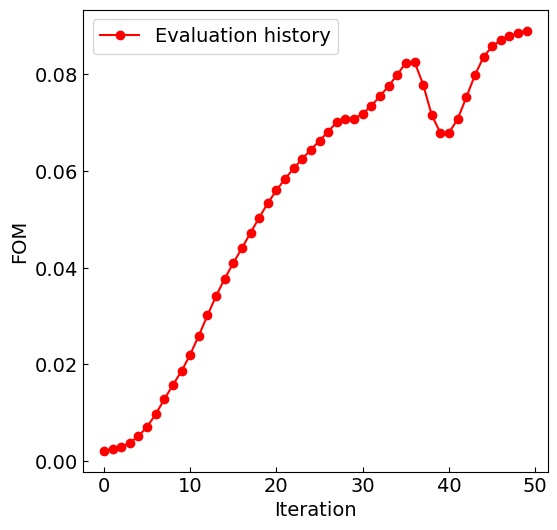

In [214]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history_adam, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

In [ ]:
# np.savetxt("init_design.txt", x_history[init_idx])
# np.savetxt("best_design.txt", x_history[best_idx])
# np.savetxt("last_design.txt", x_history[last_idx])

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_mean_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_1lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos.txt", design_variables.weights)

In [ ]:
# import numpy as np

# data = np.loadtxt('adam_weights_1lambda_pos_new_objf.txt')

# print("Loaded array shape:", data.shape)

# opt.update_design([data])
# # data


Loaded array shape: (6171,)


In [ ]:
# data_init = np.loadtxt('init_design.txt')
# data_best = np.loadtxt('best_design.txt')
# data_last = np.loadtxt('last_design.txt')

# # opt.update_design([data_init])
# # opt.update_design([data_best])
# opt.update_design([data_last])

In [ ]:
# multi = design_variables.weights
# opt.update_design([multi])

(-1.2, 1.2, 1.0154545454545456, 2.0154545454545456)

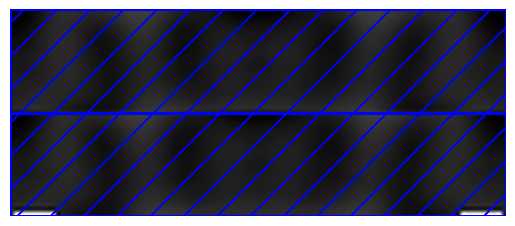

In [216]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = mp.Vector3(2.4, 1, 0), center = design_region.center),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

<Axes: xlabel='X', ylabel='Y'>

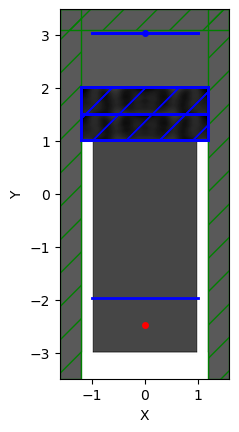

In [197]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position+1/2), mp.Vector3(mn_size,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
            center=sources.center + mp.Vector3(0, 1/fcen, 0),
                    size=mp.Vector3(width_sio2,0 ),
                    ),
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
                # weight=-1
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


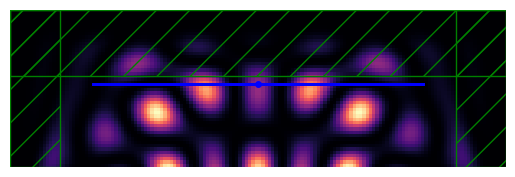

In [198]:
opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10/df, mp.Ez, sources.center, 1e-3))

opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

<Axes: xlabel='X', ylabel='Y'>

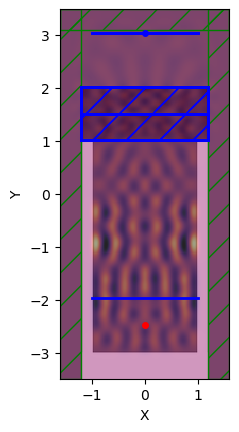

In [199]:
opt.sim.plot2D(fields = mp.Ez,
           field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 0.5,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

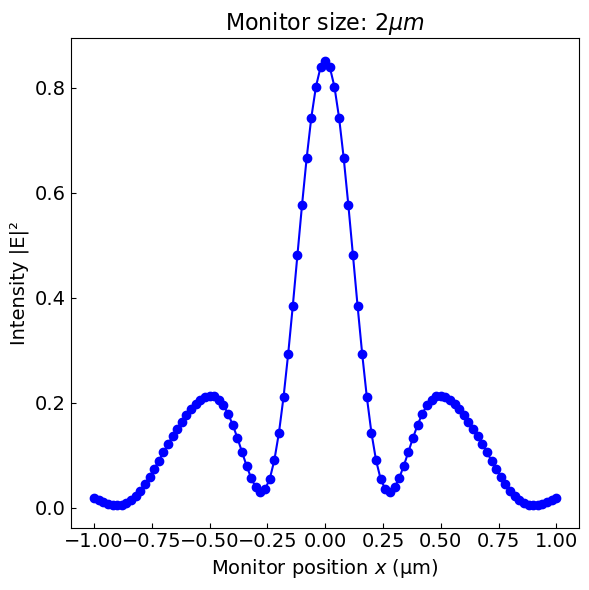

In [200]:
external_field_array = (sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

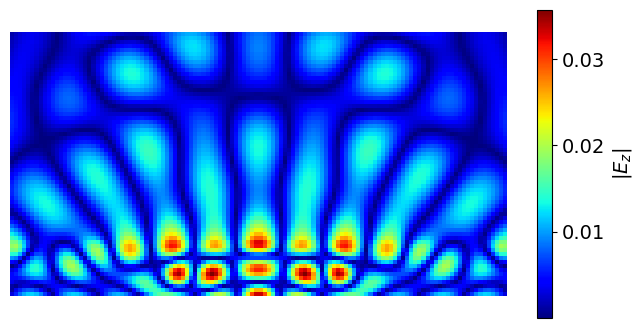

In [201]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt.sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

In [202]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

Input flux : 0.447849911237925
Output flux : 0.3173413627147607
EQE(%) : 70.85886471152381 %
